# SLCP (tractable) experiments

In [ ]:
# Importing all packages
# normalizing flows packages
import torch
from torch.distributions.beta import Beta

# loforest and locart functions
from CSI.loforest import ConformalLoforest, tune_loforest_LFI
from CSI.scores import Scores, LambdaScore, WaldoScore, BFFScore, E_valueScore
from CSI.posterior_models import normflow_posterior
from clover import LocartSplit

# quantile regression
from sklearn.ensemble import HistGradientBoostingRegressor

# plotting and numpy
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import itertools
import pandas as pd

# utils functions
from CSI.utils import obtain_quantiles, fit_post_model

# package to simulate from tractable
from hypothesis.benchmark import tractable

Computing MAE for a single N and B:

In [6]:
# function to compute MAE for a single N and B
def compute_MAE_N_B(
    kind,
    score,
    theta_grid_eval,
    simulator,
    prior,
    N = 1,
    B = 10000,
    alpha=0.05,
    min_samples_leaf = 300,
    n_estimators = 200,
    K = 50,
    B_valid= 500,
    N_lambda = 250,
    K_grid= np.concatenate((np.array([0]), np.arange(15, 105, 5))),
    naive_n=500,
    disable_tqdm = True,
    seed = 45,
    n_lambda = 300,
    log_transf = False,
    split_calib = False,
    using_beta = False,
):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    quantiles_dict = obtain_quantiles(
    kind = kind, 
    score = score, 
    theta_grid_eval = theta_grid_eval, 
    simulator = simulator,
    prior = prior, 
    N = N, 
    B = B, 
    alpha = alpha, 
    min_samples_leaf = min_samples_leaf, 
    n_estimators = n_estimators, 
    K = K,
    disable_tqdm = disable_tqdm,
    B_valid = B_valid,
    N_lambda= N_lambda,
    K_grid = K_grid,
    naive_n = naive_n,
    log_transf = log_transf,
    split_calib = split_calib,
    using_beta = using_beta,
)
    mae_list, se_list, methods_list, N_list, B_list = [], [], [], [], []
    err_data = np.zeros((theta_grid_eval.shape[0], 5))
    l = 0
    for theta in tqdm(theta_grid_eval, desc = "Evaluating coverage in this setting"):
        if theta_grid_eval.ndim == 1:
            theta_repeated = torch.tensor([theta]).reshape(1, -1).repeat_interleave(repeats = n_lambda*N, dim = 0)
        else:
            theta_repeated = torch.tensor([theta]).repeat_interleave(repeats = n_lambda*N, dim = 0)
            
        # simulating lambdas for testing
        X_net = simulator(theta_repeated)
        if log_transf:
            X_net = torch.log(X_net)
        X_dim = X_net.shape[1]
        X_net = X_net.reshape(n_lambda, N * X_dim)

        stat = score.compute(theta_repeated.numpy()[0:n_lambda, :], X_net.numpy(), disable_tqdm = True)
                
        # comparing coverage of methods
        locart_cover = np.mean(stat <= quantiles_dict["locart"][l])
        loforest_cover = np.mean(stat <= quantiles_dict["loforest_fixed"][l])
        loforest_tuned_cover = np.mean(stat <= quantiles_dict["loforest_tuned"][l])
        boosting_cover = np.mean(stat <= quantiles_dict["boosting"][l])
        naive_cover = np.mean(stat <= quantiles_dict["naive"][l])

        # appending the errors
        err_locart = np.abs(locart_cover - (1 - alpha))
        err_loforest = np.abs(loforest_cover - (1 - alpha))
        err_loforest_tuned = np.abs(loforest_tuned_cover - (1 - alpha))
        err_boosting = np.abs(boosting_cover - (1 - alpha))
        err_naive = np.abs(naive_cover - (1 - alpha))
        
            # saving in numpy array
        err_data[l, :] = np.array([err_locart, err_loforest, err_loforest_tuned, err_boosting, err_naive])
        l += 1

    mae_list.extend(np.mean(err_data, axis=0).tolist())
    se_list.extend((np.std(err_data, axis=0) / np.sqrt(theta_grid_eval.shape[0])).tolist())
    methods_list.extend(["LOCART", "LOFOREST", "tuned LOFOREST", "boosting", "monte-carlo"])
    N_list.extend([N] * 5)
    B_list.extend([B] * 5)

    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

Defining simulator and evaluation grid:

In [7]:
simulator = tractable.Simulator()
prior = tractable.Prior()

# tractable grid
n_par = 5
pars = np.linspace(-2.9, 2.9, n_par)
pars[pars == 0] = 0.01
thetas_valid = np.c_[list(itertools.product(pars, pars, pars, pars, pars))]

Fitting posterior model for $n = 5$:

Fitting normalizing flows posterior estimator:  41%|████      | 2033/5000 [05:47<08:27,  5.85it/s]


Early stopping at epoch 2033
a


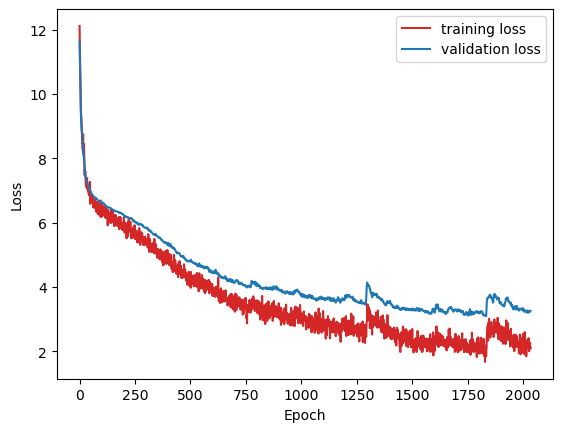

In [8]:
nflow_post_tractable = fit_post_model(
    simulator = simulator, 
    prior = prior, 
    B_model = 20000, 
    n = 10, 
    seed = 0, 
    split_seed = 125, 
    patience = 200,
    n_flows = 4,
    log_transf = False,
    n_epochs = 5000,
    )

In [9]:
# defining scores
# waldo score
waldo_score = WaldoScore(nflow_post_tractable, is_fitted = True)
waldo_score.fit()

# BFF score
bff_score = BFFScore(nflow_post_tractable, is_fitted = True)
bff_score.fit()

# e-value score
e_value_score = E_valueScore(nflow_post_tractable, is_fitted = True)
e_value_score.fit()

## Comparing all models for $n = 5$

Considering a beta prior over the calibration set:

In [11]:
bff_stats_tractable = compute_MAE_N_B(
    kind = "tractable", 
    score = bff_score, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 10, 
    B = 10000, 
    B_valid = 1000, 
    N_lambda = 500,
    seed = 125,
    K = 70,
    n_estimators = 200,
    min_samples_leaf = 300,
    log_transf = False,
    split_calib = False,
    using_beta = False,
    )

Running naive method


fitting monte carlo cutoffs: 32it [00:35,  1.12s/it]


[-0.1552694  -0.10244233 -0.01885295 ... -1.8801086  -0.00492216
 -1.115919  ]
Running all the other methods
Obtaining tuning samples


Simulating all tuning samples: 100%|██████████| 1000/1000 [21:09<00:00,  1.27s/it]


Fitting tuned loforest


Evaluating coverage in this setting: 100%|██████████| 3125/3125 [36:10<00:00,  1.44it/s]


In [12]:
bff_stats_tractable

,methods,N,B,MAE,se
0,LOCART,10,10000,0.051069,0.000905
1,LOFOREST,10,10000,0.045825,0.000777
2,tuned LOFOREST,10,10000,0.042976,0.000760
3,boosting,10,10000,0.050430,0.000713
4,monte-carlo,10,10000,0.046006,0.000159


second, for WALDO:

In [12]:
waldo_stats_tractable_beta = compute_MAE_N_B(
    kind = "tractable", 
    score = waldo_score, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 5, 
    B = 10000, 
    B_valid = 300, 
    N_lambda = 150,
    seed = 125,
    K = 70,
    n_estimators = 250,
    min_samples_leaf = 250,
    log_transf = False,
    split_calib = False,
    using_beta = True,
    )

Running naive method


fitting monte carlo cutoffs: 32it [36:01, 67.55s/it]


[ 5.8245938   4.91144633  6.41579278 ...  3.94845991  7.20265888
 10.86673745]
Running all the other methods
Obtaining tuning sample


Simulating all tuning sample: 100%|██████████| 300/300 [1:33:50<00:00, 18.77s/it]


Fitting tuned loforest


Evaluating coverage in this setting:  20%|██        | 633/3125 [6:49:28<26:52:01, 38.81s/it]


AssertionError: 

In [ ]:
waldo_stats_tractable_beta

finally, for e-value:

In [ ]:
e_value_stats_tractable_beta = compute_MAE_N_B(
    kind = "tractable", 
    score = e_value_score, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 5, 
    B = 10000, 
    B_valid = 300, 
    N_lambda = 150,
    seed = 125,
    K = 70,
    n_estimators = 250,
    min_samples_leaf = 250,
    log_transf = False,
    split_calib = False,
    using_beta = True,
    )

In [ ]:
e_value_stats_tractable_beta

## Changing $n$ to 1:

## Evaluating for several $n$ and $B$: